1000 [D loss: 0.041275, acc: 100.00%] [G loss: 3.828972]


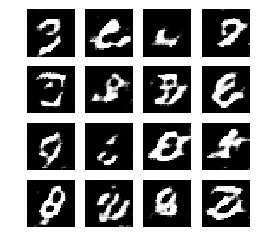

2000 [D loss: 0.659929, acc: 64.06%] [G loss: 2.749804]


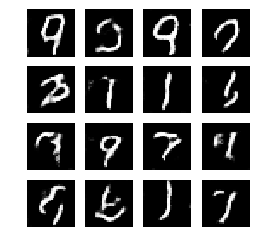

3000 [D loss: 0.189280, acc: 94.53%] [G loss: 2.531189]


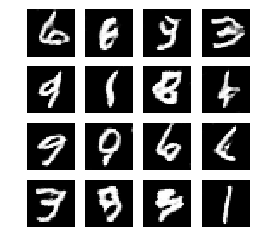

4000 [D loss: 0.041000, acc: 100.00%] [G loss: 4.493443]


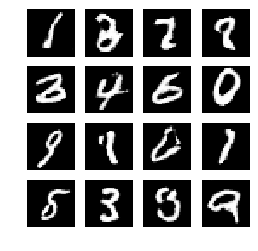

5000 [D loss: 0.110381, acc: 98.44%] [G loss: 3.902164]


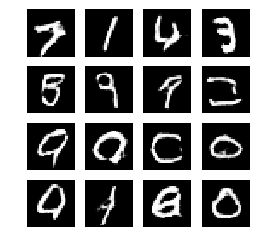

6000 [D loss: 0.103385, acc: 98.44%] [G loss: 3.441460]


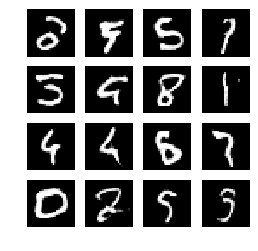

7000 [D loss: 0.063773, acc: 99.22%] [G loss: 4.591849]


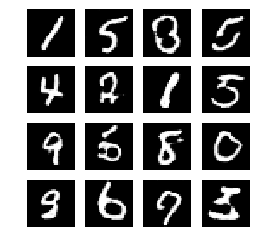

8000 [D loss: 0.086856, acc: 98.05%] [G loss: 2.521845]


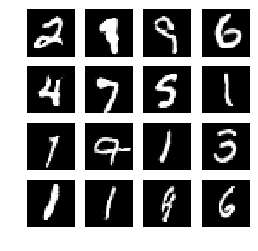

9000 [D loss: 0.040014, acc: 100.00%] [G loss: 5.367833]


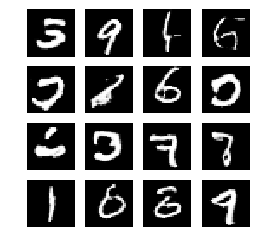

10000 [D loss: 0.021266, acc: 100.00%] [G loss: 4.091186]


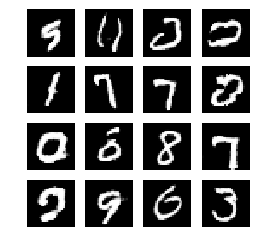

11000 [D loss: 0.082160, acc: 98.83%] [G loss: 4.309640]


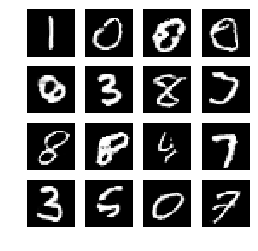

12000 [D loss: 0.012119, acc: 100.00%] [G loss: 5.973137]


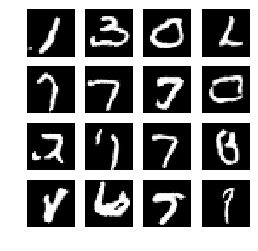

13000 [D loss: 0.021243, acc: 99.22%] [G loss: 4.220049]


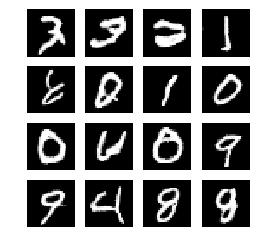

14000 [D loss: 0.068998, acc: 98.83%] [G loss: 5.605789]


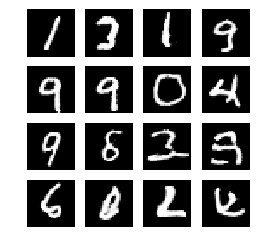

15000 [D loss: 0.116434, acc: 96.88%] [G loss: 5.688581]


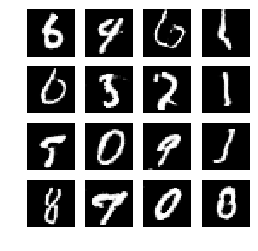

16000 [D loss: 0.072174, acc: 98.44%] [G loss: 5.661777]


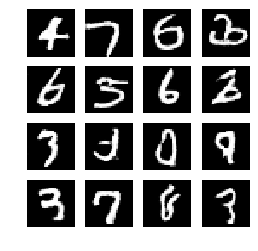

17000 [D loss: 0.087875, acc: 98.05%] [G loss: 4.806387]


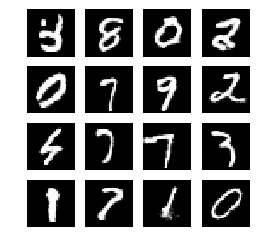

18000 [D loss: 0.071964, acc: 98.83%] [G loss: 3.704039]


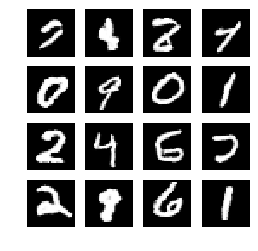

19000 [D loss: 0.002789, acc: 100.00%] [G loss: 3.519938]


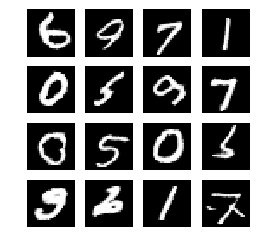

20000 [D loss: 0.023252, acc: 99.61%] [G loss: 7.618575]


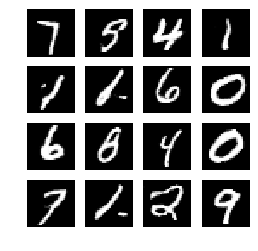

In [5]:
import matplotlib.pyplot as plt
import numpy as np 
from keras.datasets import mnist 
from keras.optimizers import Adam 
from generator import build_generator
from discriminator import build_discriminator
from gan import build_gan

img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

discriminator = build_discriminator(img_shape)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

generator = build_generator(z_dim)
discriminator.trainable = False 

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

losses = []
accuracies = []
iteration_checkpoints = []

def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    
    gen_imgs = generator.predict(z)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(
        image_grid_rows,
        image_grid_columns,
        figsize=(4,4),
        sharey=True,
        sharex=True
    )

    count = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i,j].imshow(gen_imgs[count, :, :, 0], cmap='gray')
            axs[i,j].axis('off')
            count += 1
            
    plt.show()

def train(iterations, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()

    X_train = X_train / 127.5 - 1
    X_train = np.expand_dims(X_train, axis=-1)

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        g_loss = gan.train_on_batch(z, real) # attack

        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss,  g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" %
                (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            sample_images(generator)

if __name__ == "__main__":
    iterations = 20000
    batch_size = 128
    sample_interval = 1000

    train(iterations, batch_size, sample_interval)
